In this notebook, we will go over using Wandb (weights and biases) with keras . WandB is a cloud based collaboration/visualization tool for deep learning. It can track experiments, save model checkpoints and help visualize the internal states of the model as training progresses.

This is just Tonmoy's CNN notebook with a few cells modified to incorporate WandB. 

In [1]:
# from google.colab import drive
# drive.mount('/content/drive')

## (i) Importing the necessary packages (no change)

In [2]:
import numpy as np
import pandas as pd
import keras
from keras.models import Sequential
from keras.layers import Dense, Activation, Flatten,Dropout
from keras.layers import Conv2D,BatchNormalization,MaxPooling2D,Reshape,LSTM
from keras.utils import to_categorical
import matplotlib.pyplot as plt

2023-03-18 11:26:02.835444: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


## (ii)(a) Loading and visualizing the dataset (no change)

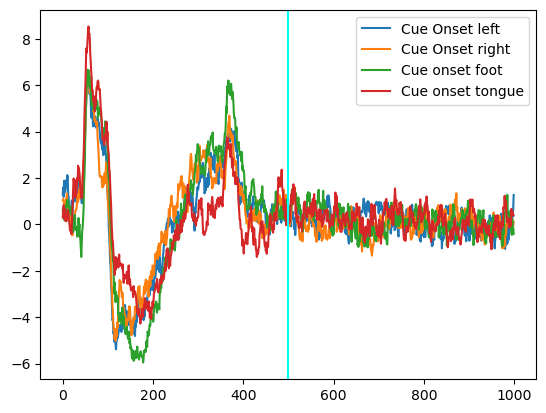

In [3]:
## Loading and visualizing the data

## Loading the dataset


X_test = np.load("X_test.npy")
y_test = np.load("y_test.npy")
person_train_valid = np.load("person_train_valid.npy")
X_train_valid = np.load("X_train_valid.npy")
y_train_valid = np.load("y_train_valid.npy")
person_test = np.load("person_test.npy")

## Adjusting the labels so that 

# Cue onset left - 0
# Cue onset right - 1
# Cue onset foot - 2
# Cue onset tongue - 3

y_train_valid -= 769
y_test -= 769

## Visualizing the data

ch_data = X_train_valid[:,8,:] # extracts the 9th channel from the data


class_0_ind = np.where(y_train_valid == 0) # finds the indices where the label is 0
ch_data_class_0 = ch_data[class_0_ind] # finds the data where label is 0
avg_ch_data_class_0 = np.mean(ch_data_class_0,axis=0) # finds the average representation of the 9th channel when label is 0


class_1_ind = np.where(y_train_valid == 1)
ch_data_class_1 = ch_data[class_1_ind]
avg_ch_data_class_1 = np.mean(ch_data_class_1,axis=0)

class_2_ind = np.where(y_train_valid == 2)
ch_data_class_2 = ch_data[class_2_ind]
avg_ch_data_class_2 = np.mean(ch_data_class_2,axis=0)

class_3_ind = np.where(y_train_valid == 3)
ch_data_class_3 = ch_data[class_3_ind]
avg_ch_data_class_3 = np.mean(ch_data_class_3,axis=0)


plt.plot(np.arange(1000),avg_ch_data_class_0)
plt.plot(np.arange(1000),avg_ch_data_class_1)
plt.plot(np.arange(1000),avg_ch_data_class_2)
plt.plot(np.arange(1000),avg_ch_data_class_3)
plt.axvline(x=500, label='line at t=500',c='cyan')

plt.legend(["Cue Onset left", "Cue Onset right", "Cue onset foot", "Cue onset tongue"])





 # Install and Import wandb

 To use WandB, you must create an account at https://wandb.ai/site. We would recommend using the same email address for Google colab 

In [4]:
!pip install -qU wandb

In [5]:
import wandb
from wandb.keras import WandbMetricsLogger, WandbModelCheckpoint, WandbEvalCallback
from wandb.keras import WandbCallback

wandb.login()

wandb: Currently logged in as: liam-greubel. Use `wandb login --relogin` to force relogin


True

## (ii)(b) Preprocessing the dataset (no change)

![EEG_prep.png](attachment:EEG_prep.png)

In [6]:
def data_prep(X,y,sub_sample,average,noise):
    
    total_X = None
    total_y = None
    
    # Trimming the data (sample,22,1000) -> (sample,22,500)
    X = X[:,:,0:500]
    print('Shape of X after trimming:',X.shape)
    
    # Maxpooling the data (sample,22,1000) -> (sample,22,500/sub_sample)
    X_max = np.max(X.reshape(X.shape[0], X.shape[1], -1, sub_sample), axis=3)
    
    
    total_X = X_max
    total_y = y
    print('Shape of X after maxpooling:',total_X.shape)
    
    # Averaging + noise 
    X_average = np.mean(X.reshape(X.shape[0], X.shape[1], -1, average),axis=3)
    X_average = X_average + np.random.normal(0.0, 0.5, X_average.shape)
    
    total_X = np.vstack((total_X, X_average))
    total_y = np.hstack((total_y, y))
    print('Shape of X after averaging+noise and concatenating:',total_X.shape)
    
    # Subsampling
    
    for i in range(sub_sample):
        
        X_subsample = X[:, :, i::sub_sample] + \
                            (np.random.normal(0.0, 0.5, X[:, :,i::sub_sample].shape) if noise else 0.0)
            
        total_X = np.vstack((total_X, X_subsample))
        total_y = np.hstack((total_y, y))
        
    
    print('Shape of X after subsampling and concatenating:',total_X.shape)
    return total_X,total_y


X_train_valid_prep,y_train_valid_prep = data_prep(X_train_valid,y_train_valid,2,2,True)


Shape of X after trimming: (2115, 22, 500)
Shape of X after maxpooling: (2115, 22, 250)
Shape of X after averaging+noise and concatenating: (4230, 22, 250)
Shape of X after subsampling and concatenating: (8460, 22, 250)


## (ii)(c) Preparing the training, validation, and test datasets (no change)

In [7]:
## Random splitting and reshaping the data
# First generating the training and validation indices using random splitting

ind_valid = np.random.choice(2115, 375, replace=False)
ind_train = np.array(list(set(range(2115)).difference(set(ind_valid))))

# Creating the training and validation sets using the generated indices
(X_train, X_valid) = X_train_valid[ind_train], X_train_valid[ind_valid] 
(y_train, y_valid) = y_train_valid[ind_train], y_train_valid[ind_valid]


## Preprocessing the dataset
x_train,y_train = data_prep(X_train,y_train,2,2,True)
x_valid,y_valid = data_prep(X_valid,y_valid,2,2,True)
X_test_prep,y_test_prep = data_prep(X_test,y_test,2,2,True)


print('Shape of testing set:',X_test_prep.shape)
print('Shape of testing labels:',y_test_prep.shape)

print('Shape of training set:',x_train.shape)
print('Shape of validation set:',x_valid.shape)
print('Shape of training labels:',y_train.shape)
print('Shape of validation labels:',y_valid.shape)



# Converting the labels to categorical variables for multiclass classification
y_train = to_categorical(y_train, 4)
y_valid = to_categorical(y_valid, 4)
y_test = to_categorical(y_test_prep, 4)
print('Shape of training labels after categorical conversion:',y_train.shape)
print('Shape of validation labels after categorical conversion:',y_valid.shape)
print('Shape of test labels after categorical conversion:',y_test.shape)

# Adding width of the segment to be 1
x_train = x_train.reshape(x_train.shape[0], x_train.shape[1], x_train.shape[2], 1)
x_valid = x_valid.reshape(x_valid.shape[0], x_valid.shape[1], x_train.shape[2], 1)
x_test = X_test_prep.reshape(X_test_prep.shape[0], X_test_prep.shape[1], X_test_prep.shape[2], 1)
print('Shape of training set after adding width info:',x_train.shape)
print('Shape of validation set after adding width info:',x_valid.shape)
print('Shape of test set after adding width info:',x_test.shape)


# Reshaping the training and validation dataset
x_train = np.swapaxes(x_train, 1,3)
x_train = np.swapaxes(x_train, 1,2)
x_valid = np.swapaxes(x_valid, 1,3)
x_valid = np.swapaxes(x_valid, 1,2)
x_test = np.swapaxes(x_test, 1,3)
x_test = np.swapaxes(x_test, 1,2)
print('Shape of training set after dimension reshaping:',x_train.shape)
print('Shape of validation set after dimension reshaping:',x_valid.shape)
print('Shape of test set after dimension reshaping:',x_test.shape)
    



Shape of X after trimming: (1740, 22, 500)
Shape of X after maxpooling: (1740, 22, 250)
Shape of X after averaging+noise and concatenating: (3480, 22, 250)
Shape of X after subsampling and concatenating: (6960, 22, 250)
Shape of X after trimming: (375, 22, 500)
Shape of X after maxpooling: (375, 22, 250)
Shape of X after averaging+noise and concatenating: (750, 22, 250)
Shape of X after subsampling and concatenating: (1500, 22, 250)
Shape of X after trimming: (443, 22, 500)
Shape of X after maxpooling: (443, 22, 250)
Shape of X after averaging+noise and concatenating: (886, 22, 250)
Shape of X after subsampling and concatenating: (1772, 22, 250)
Shape of testing set: (1772, 22, 250)
Shape of testing labels: (1772,)
Shape of training set: (6960, 22, 250)
Shape of validation set: (1500, 22, 250)
Shape of training labels: (6960,)
Shape of validation labels: (1500,)
Shape of training labels after categorical conversion: (6960, 4)
Shape of validation labels after categorical conversion: (15

## (iii)(CNN) Defining the architecture of a basic CNN model (no change)

In [8]:
# Building the CNN model using sequential class
hybrid_cnn_lstm_model = Sequential()

# Conv. block 1
hybrid_cnn_lstm_model.add(Conv2D(filters=25, kernel_size=(5,1), padding='same', activation='elu', input_shape=(250,1,22)))
hybrid_cnn_lstm_model.add(MaxPooling2D(pool_size=(3,1), padding='same')) # Read the keras documentation
hybrid_cnn_lstm_model.add(BatchNormalization())
hybrid_cnn_lstm_model.add(Dropout(0.5))

# Conv. block 2
hybrid_cnn_lstm_model.add(Conv2D(filters=50, kernel_size=(5,1), padding='same', activation='elu'))
hybrid_cnn_lstm_model.add(MaxPooling2D(pool_size=(3,1), padding='same'))
hybrid_cnn_lstm_model.add(BatchNormalization())
hybrid_cnn_lstm_model.add(Dropout(0.5))

# Conv. block 3
hybrid_cnn_lstm_model.add(Conv2D(filters=100, kernel_size=(5,1), padding='same', activation='elu'))
hybrid_cnn_lstm_model.add(MaxPooling2D(pool_size=(3,1), padding='same'))
hybrid_cnn_lstm_model.add(BatchNormalization())
hybrid_cnn_lstm_model.add(Dropout(0.5))

# Conv. block 4
hybrid_cnn_lstm_model.add(Conv2D(filters=200, kernel_size=(5,1), padding='same', activation='elu'))
hybrid_cnn_lstm_model.add(MaxPooling2D(pool_size=(3,1), padding='same'))
hybrid_cnn_lstm_model.add(BatchNormalization())
hybrid_cnn_lstm_model.add(Dropout(0.5))

# FC+LSTM layers
hybrid_cnn_lstm_model.add(Flatten()) # Adding a flattening operation to the output of CNN block
hybrid_cnn_lstm_model.add(Dense((350))) # FC layer with 100 units
hybrid_cnn_lstm_model.add(Reshape((350,1))) # Reshape my output of FC layer so that it's compatible
hybrid_cnn_lstm_model.add(LSTM(35, dropout=0.6, recurrent_dropout=0.1, input_shape=(350,1), return_sequences=False))

# Output layer with Softmax activation 
hybrid_cnn_lstm_model.add(Dense(4, activation='softmax')) # Output FC layer with softmax activation


# Printing the model summary
hybrid_cnn_lstm_model.summary()


2023-03-18 11:26:30.867827: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 250, 1, 25)        2775      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 84, 1, 25)        0         
 )                                                               
                                                                 
 batch_normalization (BatchN  (None, 84, 1, 25)        100       
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 84, 1, 25)         0         
                                                                 
 conv2d_1 (Conv2D)           (None, 84, 1, 50)         6300      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 28, 1, 50)        0

# Create and run model using wandb

In [9]:
# Call wandb.init() before anything else!

run = wandb.init(project='CNN_EEG_3',
                 config={  # and include hyperparameters and metadata
                     "learning_rate": 5e-3,
                     "epochs": 50,
                     "batch_size": 64,
                     "loss_function": "categorical_crossentropy",
                     #"architecture": "CNN",
                     "dataset": "EEG-preprocessed"
                 })
config = wandb.config 


In [10]:
# Compiling the model
cnn_optimizer = keras.optimizers.Adam(lr=config.learning_rate)
hybrid_cnn_lstm_model.compile(loss=config.loss_function,
                 optimizer=cnn_optimizer,
                 metrics=['accuracy'])
wandb_callbacks = [
    WandbMetricsLogger(),
    WandbModelCheckpoint(filepath="my_model_{epoch:02d}"),
]

# Training and validating the model
hybrid_cnn_lstm_model_results = hybrid_cnn_lstm_model.fit(x_train,
             y_train,
             batch_size=config.batch_size,
             epochs=config.epochs,
             validation_data=(x_valid, y_valid), callbacks=wandb_callbacks,verbose=True)
run.finish()

# When you run this, the cell output shows links to your wandb dashboard

/Users/liamgreubel/opt/anaconda3/lib/python3.9/site-packages/keras/optimizers/optimizer_v2/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


Epoch 1/50
109/109 [==============================] - ETA: 0s - loss: 1.3362 - accuracy: 0.3364

INFO:tensorflow:Assets written to: my_model_01/assets


INFO:tensorflow:Assets written to: my_model_01/assets
wandb: Adding directory to artifact (./my_model_01)... Done. 0.1s


109/109 [==============================] - 56s 478ms/step - loss: 1.3362 - accuracy: 0.3364 - val_loss: 1.2792 - val_accuracy: 0.4187
Epoch 2/50
109/109 [==============================] - ETA: 0s - loss: 1.2419 - accuracy: 0.4295

INFO:tensorflow:Assets written to: my_model_02/assets


INFO:tensorflow:Assets written to: my_model_02/assets
wandb: Adding directory to artifact (./my_model_02)... Done. 0.1s


109/109 [==============================] - 47s 436ms/step - loss: 1.2419 - accuracy: 0.4295 - val_loss: 1.3624 - val_accuracy: 0.3720
Epoch 3/50
109/109 [==============================] - ETA: 0s - loss: 1.1827 - accuracy: 0.4622

INFO:tensorflow:Assets written to: my_model_03/assets


INFO:tensorflow:Assets written to: my_model_03/assets
wandb: Adding directory to artifact (./my_model_03)... Done. 0.0s


109/109 [==============================] - 49s 447ms/step - loss: 1.1827 - accuracy: 0.4622 - val_loss: 1.1879 - val_accuracy: 0.4660
Epoch 4/50
109/109 [==============================] - ETA: 0s - loss: 1.1516 - accuracy: 0.4859

INFO:tensorflow:Assets written to: my_model_04/assets


INFO:tensorflow:Assets written to: my_model_04/assets
wandb: Adding directory to artifact (./my_model_04)... Done. 0.0s


109/109 [==============================] - 49s 452ms/step - loss: 1.1516 - accuracy: 0.4859 - val_loss: 1.1448 - val_accuracy: 0.4793
Epoch 5/50
109/109 [==============================] - ETA: 0s - loss: 1.1131 - accuracy: 0.5010

INFO:tensorflow:Assets written to: my_model_05/assets


INFO:tensorflow:Assets written to: my_model_05/assets
wandb: Adding directory to artifact (./my_model_05)... Done. 0.0s


109/109 [==============================] - 50s 459ms/step - loss: 1.1131 - accuracy: 0.5010 - val_loss: 1.1755 - val_accuracy: 0.4620
Epoch 6/50
109/109 [==============================] - ETA: 0s - loss: 1.0799 - accuracy: 0.5152

INFO:tensorflow:Assets written to: my_model_06/assets


INFO:tensorflow:Assets written to: my_model_06/assets
wandb: Adding directory to artifact (./my_model_06)... Done. 0.0s


109/109 [==============================] - 47s 431ms/step - loss: 1.0799 - accuracy: 0.5152 - val_loss: 1.0880 - val_accuracy: 0.5407
Epoch 7/50
109/109 [==============================] - ETA: 0s - loss: 1.0746 - accuracy: 0.5274

INFO:tensorflow:Assets written to: my_model_07/assets


INFO:tensorflow:Assets written to: my_model_07/assets
wandb: Adding directory to artifact (./my_model_07)... Done. 0.1s


109/109 [==============================] - 48s 439ms/step - loss: 1.0746 - accuracy: 0.5274 - val_loss: 1.1558 - val_accuracy: 0.5040
Epoch 8/50
109/109 [==============================] - ETA: 0s - loss: 1.0439 - accuracy: 0.5398

INFO:tensorflow:Assets written to: my_model_08/assets


INFO:tensorflow:Assets written to: my_model_08/assets
wandb: Adding directory to artifact (./my_model_08)... Done. 0.0s


109/109 [==============================] - 47s 429ms/step - loss: 1.0439 - accuracy: 0.5398 - val_loss: 1.0890 - val_accuracy: 0.5233
Epoch 9/50
109/109 [==============================] - ETA: 0s - loss: 1.0298 - accuracy: 0.5453

INFO:tensorflow:Assets written to: my_model_09/assets


INFO:tensorflow:Assets written to: my_model_09/assets
wandb: Adding directory to artifact (./my_model_09)... Done. 0.0s


109/109 [==============================] - 46s 427ms/step - loss: 1.0298 - accuracy: 0.5453 - val_loss: 1.0510 - val_accuracy: 0.5520
Epoch 10/50
109/109 [==============================] - ETA: 0s - loss: 1.0032 - accuracy: 0.5665

INFO:tensorflow:Assets written to: my_model_10/assets


INFO:tensorflow:Assets written to: my_model_10/assets
wandb: Adding directory to artifact (./my_model_10)... Done. 0.0s


109/109 [==============================] - 49s 447ms/step - loss: 1.0032 - accuracy: 0.5665 - val_loss: 1.1175 - val_accuracy: 0.5040
Epoch 11/50
109/109 [==============================] - ETA: 0s - loss: 0.9955 - accuracy: 0.5658

INFO:tensorflow:Assets written to: my_model_11/assets


INFO:tensorflow:Assets written to: my_model_11/assets
wandb: Adding directory to artifact (./my_model_11)... Done. 0.0s


109/109 [==============================] - 49s 446ms/step - loss: 0.9955 - accuracy: 0.5658 - val_loss: 1.0933 - val_accuracy: 0.5507
Epoch 12/50
109/109 [==============================] - ETA: 0s - loss: 0.9770 - accuracy: 0.5760

INFO:tensorflow:Assets written to: my_model_12/assets


INFO:tensorflow:Assets written to: my_model_12/assets
wandb: Adding directory to artifact (./my_model_12)... Done. 0.1s


109/109 [==============================] - 46s 427ms/step - loss: 0.9770 - accuracy: 0.5760 - val_loss: 1.0812 - val_accuracy: 0.5260
Epoch 13/50
109/109 [==============================] - ETA: 0s - loss: 0.9510 - accuracy: 0.5846

INFO:tensorflow:Assets written to: my_model_13/assets


INFO:tensorflow:Assets written to: my_model_13/assets
wandb: Adding directory to artifact (./my_model_13)... Done. 0.0s


109/109 [==============================] - 49s 449ms/step - loss: 0.9510 - accuracy: 0.5846 - val_loss: 1.0425 - val_accuracy: 0.5427
Epoch 14/50
109/109 [==============================] - ETA: 0s - loss: 0.9425 - accuracy: 0.5986

INFO:tensorflow:Assets written to: my_model_14/assets


INFO:tensorflow:Assets written to: my_model_14/assets
wandb: Adding directory to artifact (./my_model_14)... Done. 0.1s


109/109 [==============================] - 45s 418ms/step - loss: 0.9425 - accuracy: 0.5986 - val_loss: 1.0585 - val_accuracy: 0.5587
Epoch 15/50
109/109 [==============================] - ETA: 0s - loss: 0.9207 - accuracy: 0.5978

INFO:tensorflow:Assets written to: my_model_15/assets


INFO:tensorflow:Assets written to: my_model_15/assets
wandb: Adding directory to artifact (./my_model_15)... Done. 0.0s


109/109 [==============================] - 46s 421ms/step - loss: 0.9207 - accuracy: 0.5978 - val_loss: 1.0783 - val_accuracy: 0.5500
Epoch 16/50
109/109 [==============================] - ETA: 0s - loss: 0.9253 - accuracy: 0.6003

INFO:tensorflow:Assets written to: my_model_16/assets


INFO:tensorflow:Assets written to: my_model_16/assets
wandb: Adding directory to artifact (./my_model_16)... Done. 0.0s


109/109 [==============================] - 46s 427ms/step - loss: 0.9253 - accuracy: 0.6003 - val_loss: 1.0477 - val_accuracy: 0.5640
Epoch 17/50
109/109 [==============================] - ETA: 0s - loss: 0.8965 - accuracy: 0.6220

INFO:tensorflow:Assets written to: my_model_17/assets


INFO:tensorflow:Assets written to: my_model_17/assets
wandb: Adding directory to artifact (./my_model_17)... Done. 0.0s


109/109 [==============================] - 46s 422ms/step - loss: 0.8965 - accuracy: 0.6220 - val_loss: 1.0230 - val_accuracy: 0.6033
Epoch 18/50
109/109 [==============================] - ETA: 0s - loss: 0.8985 - accuracy: 0.6210

INFO:tensorflow:Assets written to: my_model_18/assets


INFO:tensorflow:Assets written to: my_model_18/assets
wandb: Adding directory to artifact (./my_model_18)... Done. 0.0s


109/109 [==============================] - 45s 418ms/step - loss: 0.8985 - accuracy: 0.6210 - val_loss: 1.0395 - val_accuracy: 0.5727
Epoch 19/50
109/109 [==============================] - ETA: 0s - loss: 0.8719 - accuracy: 0.6263

INFO:tensorflow:Assets written to: my_model_19/assets


INFO:tensorflow:Assets written to: my_model_19/assets
wandb: Adding directory to artifact (./my_model_19)... Done. 0.0s


109/109 [==============================] - 46s 426ms/step - loss: 0.8719 - accuracy: 0.6263 - val_loss: 1.0970 - val_accuracy: 0.5433
Epoch 20/50
109/109 [==============================] - ETA: 0s - loss: 0.8570 - accuracy: 0.6461

INFO:tensorflow:Assets written to: my_model_20/assets


INFO:tensorflow:Assets written to: my_model_20/assets
wandb: Adding directory to artifact (./my_model_20)... Done. 0.0s


109/109 [==============================] - 44s 405ms/step - loss: 0.8570 - accuracy: 0.6461 - val_loss: 1.0295 - val_accuracy: 0.5920
Epoch 21/50
109/109 [==============================] - ETA: 0s - loss: 0.8509 - accuracy: 0.6468

INFO:tensorflow:Assets written to: my_model_21/assets


INFO:tensorflow:Assets written to: my_model_21/assets
wandb: Adding directory to artifact (./my_model_21)... Done. 0.0s


109/109 [==============================] - 44s 407ms/step - loss: 0.8509 - accuracy: 0.6468 - val_loss: 1.0203 - val_accuracy: 0.6000
Epoch 22/50
109/109 [==============================] - ETA: 0s - loss: 0.8279 - accuracy: 0.6560

INFO:tensorflow:Assets written to: my_model_22/assets


INFO:tensorflow:Assets written to: my_model_22/assets
wandb: Adding directory to artifact (./my_model_22)... Done. 0.0s


109/109 [==============================] - 45s 415ms/step - loss: 0.8279 - accuracy: 0.6560 - val_loss: 1.0164 - val_accuracy: 0.5987
Epoch 23/50
109/109 [==============================] - ETA: 0s - loss: 0.8292 - accuracy: 0.6628

INFO:tensorflow:Assets written to: my_model_23/assets


INFO:tensorflow:Assets written to: my_model_23/assets
wandb: Adding directory to artifact (./my_model_23)... Done. 0.0s


109/109 [==============================] - 45s 409ms/step - loss: 0.8292 - accuracy: 0.6628 - val_loss: 1.0073 - val_accuracy: 0.6080
Epoch 24/50
109/109 [==============================] - ETA: 0s - loss: 0.8087 - accuracy: 0.6754

INFO:tensorflow:Assets written to: my_model_24/assets


INFO:tensorflow:Assets written to: my_model_24/assets
wandb: Adding directory to artifact (./my_model_24)... Done. 0.1s


109/109 [==============================] - 44s 404ms/step - loss: 0.8087 - accuracy: 0.6754 - val_loss: 0.9272 - val_accuracy: 0.6700
Epoch 25/50
109/109 [==============================] - ETA: 0s - loss: 0.7899 - accuracy: 0.6845

INFO:tensorflow:Assets written to: my_model_25/assets


INFO:tensorflow:Assets written to: my_model_25/assets
wandb: Adding directory to artifact (./my_model_25)... Done. 0.0s


109/109 [==============================] - 45s 412ms/step - loss: 0.7899 - accuracy: 0.6845 - val_loss: 0.9144 - val_accuracy: 0.6560
Epoch 26/50
109/109 [==============================] - ETA: 0s - loss: 0.7729 - accuracy: 0.6951

INFO:tensorflow:Assets written to: my_model_26/assets


INFO:tensorflow:Assets written to: my_model_26/assets
wandb: Adding directory to artifact (./my_model_26)... Done. 0.1s


109/109 [==============================] - 44s 409ms/step - loss: 0.7729 - accuracy: 0.6951 - val_loss: 0.9178 - val_accuracy: 0.6607
Epoch 27/50
109/109 [==============================] - ETA: 0s - loss: 0.7517 - accuracy: 0.7009

INFO:tensorflow:Assets written to: my_model_27/assets


INFO:tensorflow:Assets written to: my_model_27/assets
wandb: Adding directory to artifact (./my_model_27)... Done. 0.0s


109/109 [==============================] - 44s 406ms/step - loss: 0.7517 - accuracy: 0.7009 - val_loss: 0.9040 - val_accuracy: 0.6880
Epoch 28/50
109/109 [==============================] - ETA: 0s - loss: 0.7476 - accuracy: 0.7014

INFO:tensorflow:Assets written to: my_model_28/assets


INFO:tensorflow:Assets written to: my_model_28/assets
wandb: Adding directory to artifact (./my_model_28)... Done. 0.0s


109/109 [==============================] - 45s 411ms/step - loss: 0.7476 - accuracy: 0.7014 - val_loss: 0.9307 - val_accuracy: 0.6920
Epoch 29/50
109/109 [==============================] - ETA: 0s - loss: 0.7352 - accuracy: 0.7128

INFO:tensorflow:Assets written to: my_model_29/assets


INFO:tensorflow:Assets written to: my_model_29/assets
wandb: Adding directory to artifact (./my_model_29)... Done. 0.0s


109/109 [==============================] - 44s 408ms/step - loss: 0.7352 - accuracy: 0.7128 - val_loss: 0.9360 - val_accuracy: 0.6700
Epoch 30/50
109/109 [==============================] - ETA: 0s - loss: 0.7453 - accuracy: 0.7079

INFO:tensorflow:Assets written to: my_model_30/assets


INFO:tensorflow:Assets written to: my_model_30/assets
wandb: Adding directory to artifact (./my_model_30)... Done. 0.0s


109/109 [==============================] - 44s 404ms/step - loss: 0.7453 - accuracy: 0.7079 - val_loss: 0.8856 - val_accuracy: 0.6960
Epoch 31/50
109/109 [==============================] - ETA: 0s - loss: 0.7154 - accuracy: 0.7250

INFO:tensorflow:Assets written to: my_model_31/assets


INFO:tensorflow:Assets written to: my_model_31/assets
wandb: Adding directory to artifact (./my_model_31)... Done. 0.0s


109/109 [==============================] - 45s 415ms/step - loss: 0.7154 - accuracy: 0.7250 - val_loss: 0.8449 - val_accuracy: 0.7113
Epoch 32/50
109/109 [==============================] - ETA: 0s - loss: 0.7023 - accuracy: 0.7290

INFO:tensorflow:Assets written to: my_model_32/assets


INFO:tensorflow:Assets written to: my_model_32/assets
wandb: Adding directory to artifact (./my_model_32)... Done. 0.0s


109/109 [==============================] - 44s 404ms/step - loss: 0.7023 - accuracy: 0.7290 - val_loss: 0.8926 - val_accuracy: 0.6753
Epoch 33/50
109/109 [==============================] - ETA: 0s - loss: 0.6936 - accuracy: 0.7313

INFO:tensorflow:Assets written to: my_model_33/assets


INFO:tensorflow:Assets written to: my_model_33/assets
wandb: Adding directory to artifact (./my_model_33)... Done. 0.0s


109/109 [==============================] - 46s 419ms/step - loss: 0.6936 - accuracy: 0.7313 - val_loss: 0.8383 - val_accuracy: 0.6793
Epoch 34/50
109/109 [==============================] - ETA: 0s - loss: 0.6839 - accuracy: 0.7437

INFO:tensorflow:Assets written to: my_model_34/assets


INFO:tensorflow:Assets written to: my_model_34/assets
wandb: Adding directory to artifact (./my_model_34)... Done. 0.1s


109/109 [==============================] - 45s 415ms/step - loss: 0.6839 - accuracy: 0.7437 - val_loss: 0.8783 - val_accuracy: 0.6620
Epoch 35/50
109/109 [==============================] - ETA: 0s - loss: 0.6923 - accuracy: 0.7339

INFO:tensorflow:Assets written to: my_model_35/assets


INFO:tensorflow:Assets written to: my_model_35/assets
wandb: Adding directory to artifact (./my_model_35)... Done. 0.0s


109/109 [==============================] - 45s 412ms/step - loss: 0.6923 - accuracy: 0.7339 - val_loss: 0.9054 - val_accuracy: 0.6673
Epoch 36/50
109/109 [==============================] - ETA: 0s - loss: 0.6428 - accuracy: 0.7555

INFO:tensorflow:Assets written to: my_model_36/assets


INFO:tensorflow:Assets written to: my_model_36/assets
wandb: Adding directory to artifact (./my_model_36)... Done. 0.0s


109/109 [==============================] - 47s 430ms/step - loss: 0.6428 - accuracy: 0.7555 - val_loss: 0.9015 - val_accuracy: 0.6707
Epoch 37/50
109/109 [==============================] - ETA: 0s - loss: 0.6569 - accuracy: 0.7477

INFO:tensorflow:Assets written to: my_model_37/assets


INFO:tensorflow:Assets written to: my_model_37/assets
wandb: Adding directory to artifact (./my_model_37)... Done. 0.0s


109/109 [==============================] - 45s 410ms/step - loss: 0.6569 - accuracy: 0.7477 - val_loss: 0.8212 - val_accuracy: 0.7207
Epoch 38/50
109/109 [==============================] - ETA: 0s - loss: 0.6445 - accuracy: 0.7534

INFO:tensorflow:Assets written to: my_model_38/assets


INFO:tensorflow:Assets written to: my_model_38/assets
wandb: Adding directory to artifact (./my_model_38)... Done. 0.0s


109/109 [==============================] - 44s 407ms/step - loss: 0.6445 - accuracy: 0.7534 - val_loss: 0.8570 - val_accuracy: 0.6893
Epoch 39/50
109/109 [==============================] - ETA: 0s - loss: 0.6527 - accuracy: 0.7543

INFO:tensorflow:Assets written to: my_model_39/assets


INFO:tensorflow:Assets written to: my_model_39/assets
wandb: Adding directory to artifact (./my_model_39)... Done. 0.0s


109/109 [==============================] - 45s 411ms/step - loss: 0.6527 - accuracy: 0.7543 - val_loss: 0.8736 - val_accuracy: 0.6620
Epoch 40/50
109/109 [==============================] - ETA: 0s - loss: 0.6367 - accuracy: 0.7534

INFO:tensorflow:Assets written to: my_model_40/assets


INFO:tensorflow:Assets written to: my_model_40/assets
wandb: Adding directory to artifact (./my_model_40)... Done. 0.0s


109/109 [==============================] - 45s 415ms/step - loss: 0.6367 - accuracy: 0.7534 - val_loss: 0.8443 - val_accuracy: 0.6880
Epoch 41/50
109/109 [==============================] - ETA: 0s - loss: 0.6309 - accuracy: 0.7621

INFO:tensorflow:Assets written to: my_model_41/assets


INFO:tensorflow:Assets written to: my_model_41/assets
wandb: Adding directory to artifact (./my_model_41)... Done. 0.0s


109/109 [==============================] - 44s 406ms/step - loss: 0.6309 - accuracy: 0.7621 - val_loss: 0.8888 - val_accuracy: 0.6807
Epoch 42/50
109/109 [==============================] - ETA: 0s - loss: 0.6190 - accuracy: 0.7621

INFO:tensorflow:Assets written to: my_model_42/assets


INFO:tensorflow:Assets written to: my_model_42/assets
wandb: Adding directory to artifact (./my_model_42)... Done. 0.0s


109/109 [==============================] - 46s 425ms/step - loss: 0.6190 - accuracy: 0.7621 - val_loss: 0.8647 - val_accuracy: 0.6740
Epoch 43/50
109/109 [==============================] - ETA: 0s - loss: 0.6160 - accuracy: 0.7642

INFO:tensorflow:Assets written to: my_model_43/assets


INFO:tensorflow:Assets written to: my_model_43/assets
wandb: Adding directory to artifact (./my_model_43)... Done. 0.0s


109/109 [==============================] - 44s 403ms/step - loss: 0.6160 - accuracy: 0.7642 - val_loss: 0.7887 - val_accuracy: 0.7093
Epoch 44/50
109/109 [==============================] - ETA: 0s - loss: 0.6016 - accuracy: 0.7693

INFO:tensorflow:Assets written to: my_model_44/assets


INFO:tensorflow:Assets written to: my_model_44/assets
wandb: Adding directory to artifact (./my_model_44)... Done. 0.0s


109/109 [==============================] - 46s 421ms/step - loss: 0.6016 - accuracy: 0.7693 - val_loss: 0.8135 - val_accuracy: 0.7207
Epoch 45/50
109/109 [==============================] - ETA: 0s - loss: 0.5962 - accuracy: 0.7767

INFO:tensorflow:Assets written to: my_model_45/assets


INFO:tensorflow:Assets written to: my_model_45/assets
wandb: Adding directory to artifact (./my_model_45)... Done. 0.0s


109/109 [==============================] - 46s 419ms/step - loss: 0.5962 - accuracy: 0.7767 - val_loss: 0.8353 - val_accuracy: 0.6780
Epoch 46/50
109/109 [==============================] - ETA: 0s - loss: 0.5854 - accuracy: 0.7740

INFO:tensorflow:Assets written to: my_model_46/assets


INFO:tensorflow:Assets written to: my_model_46/assets
wandb: Adding directory to artifact (./my_model_46)... Done. 0.1s


109/109 [==============================] - 45s 413ms/step - loss: 0.5854 - accuracy: 0.7740 - val_loss: 0.8433 - val_accuracy: 0.6787
Epoch 47/50
109/109 [==============================] - ETA: 0s - loss: 0.5810 - accuracy: 0.7776

INFO:tensorflow:Assets written to: my_model_47/assets


INFO:tensorflow:Assets written to: my_model_47/assets
wandb: Adding directory to artifact (./my_model_47)... Done. 0.0s


109/109 [==============================] - 46s 422ms/step - loss: 0.5810 - accuracy: 0.7776 - val_loss: 0.8577 - val_accuracy: 0.6973
Epoch 48/50
109/109 [==============================] - ETA: 0s - loss: 0.5903 - accuracy: 0.7763

INFO:tensorflow:Assets written to: my_model_48/assets


INFO:tensorflow:Assets written to: my_model_48/assets
wandb: Adding directory to artifact (./my_model_48)... Done. 0.1s


109/109 [==============================] - 45s 416ms/step - loss: 0.5903 - accuracy: 0.7763 - val_loss: 0.8861 - val_accuracy: 0.6687
Epoch 49/50
109/109 [==============================] - ETA: 0s - loss: 0.5941 - accuracy: 0.7739

INFO:tensorflow:Assets written to: my_model_49/assets


INFO:tensorflow:Assets written to: my_model_49/assets
wandb: Adding directory to artifact (./my_model_49)... Done. 0.0s


109/109 [==============================] - 46s 419ms/step - loss: 0.5941 - accuracy: 0.7739 - val_loss: 0.8609 - val_accuracy: 0.6700
Epoch 50/50
109/109 [==============================] - ETA: 0s - loss: 0.5808 - accuracy: 0.7810

INFO:tensorflow:Assets written to: my_model_50/assets


INFO:tensorflow:Assets written to: my_model_50/assets
wandb: Adding directory to artifact (./my_model_50)... Done. 0.0s


109/109 [==============================] - 44s 407ms/step - loss: 0.5808 - accuracy: 0.7810 - val_loss: 0.8302 - val_accuracy: 0.7033


epoch/accuracy,▁▂▃▃▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇▇▇█▇██████████
epoch/epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
epoch/learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/loss,█▇▇▆▆▆▅▅▅▅▄▄▄▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁
epoch/val_accuracy,▂▁▃▃▄▄▄▅▅▄▄▅▅▆▅▄▆▆▆▇▇▇▇▇█▇▇▇▇█▇▇▇▇██▇█▇█
epoch/val_loss,▇█▆▅▅▅▅▄▅▅▄▄▄▄▄▅▄▄▄▃▃▂▃▃▂▂▂▂▂▁▂▂▂▂▁▁▂▂▂▂
epoch/accuracy,0.78103
epoch/epoch,49
epoch/learning_rate,0.005
epoch/loss,0.58084
epoch/val_accuracy,0.70333


# Hyper parameter tuning with WandB

In [11]:
# Define sweep parameters 
sweep_config = {
    'method': 'random',
    'name': 'sweep',
    'metric': {
        'goal': 'minimize', 
        'name': 'val_loss'
        },
    'parameters': {
        'batch_size': {'values': [16, 32, 64]},
        'epochs': {'values': [5, 10, 15, 25, 50]},
        'lr': {'values': [1e-3, 5e-3, 1e-2]}
     }
}

In [12]:
# Entity name = username that you use to login
sweep_id = wandb.sweep(sweep_config, entity = '',project="CNN_EEG")

Create sweep with ID: b6gkxb8e
Sweep URL: https://wandb.ai/liam-greubel/CNN_EEG/sweeps/b6gkxb8e


In [13]:
# Define a function with model and parameters
# The wandb agent calls this function with each set of hyperparameters

def train():
    # Default values for hyper-parameters we're going to sweep over
    config_defaults = {
        "batch_size": 64,
        "learning_rate": 0.01,
        "epochs" : 5
    }
    # Initialize a new wandb run
    wandb.init(config=config_defaults)
    
    # Config is a variable that holds and saves hyperparameters and inputs
    config = wandb.config
    wandb.config.loss_function = "categorical_crossentropy"
#     wandb.config.architecture_name = "CNN"
    wandb.config.dataset_name = "EEG-preprocessed"
   
    # Building the CNN model using sequential class
    hybrid_cnn_lstm_model = Sequential()

    # Conv. block 1
    hybrid_cnn_lstm_model.add(Conv2D(filters=25, kernel_size=(5,1), padding='same', activation='elu', input_shape=(250,1,22)))
    hybrid_cnn_lstm_model.add(MaxPooling2D(pool_size=(3,1), padding='same')) # Read the keras documentation
    hybrid_cnn_lstm_model.add(BatchNormalization())
    hybrid_cnn_lstm_model.add(Dropout(0.5))

    # Conv. block 2
    hybrid_cnn_lstm_model.add(Conv2D(filters=50, kernel_size=(5,1), padding='same', activation='elu'))
    hybrid_cnn_lstm_model.add(MaxPooling2D(pool_size=(3,1), padding='same'))
    hybrid_cnn_lstm_model.add(BatchNormalization())
    hybrid_cnn_lstm_model.add(Dropout(0.5))

    # Conv. block 3
    hybrid_cnn_lstm_model.add(Conv2D(filters=100, kernel_size=(5,1), padding='same', activation='elu'))
    hybrid_cnn_lstm_model.add(MaxPooling2D(pool_size=(3,1), padding='same'))
    hybrid_cnn_lstm_model.add(BatchNormalization())
    hybrid_cnn_lstm_model.add(Dropout(0.5))

    # Conv. block 4
    hybrid_cnn_lstm_model.add(Conv2D(filters=200, kernel_size=(5,1), padding='same', activation='elu'))
    hybrid_cnn_lstm_model.add(MaxPooling2D(pool_size=(3,1), padding='same'))
    hybrid_cnn_lstm_model.add(BatchNormalization())
    hybrid_cnn_lstm_model.add(Dropout(0.5))

    # FC+LSTM layers
    hybrid_cnn_lstm_model.add(Flatten()) # Adding a flattening operation to the output of CNN block
    hybrid_cnn_lstm_model.add(Dense((350))) # FC layer with 100 units
    hybrid_cnn_lstm_model.add(Reshape((350,1))) # Reshape my output of FC layer so that it's compatible
    hybrid_cnn_lstm_model.add(LSTM(35, dropout=0.6, recurrent_dropout=0.1, input_shape=(350,1), return_sequences=False))

    # Output layer with Softmax activation 
    hybrid_cnn_lstm_model.add(Dense(4, activation='softmax')) # Output FC layer with softmax activation

  
    # Defining the callbacks - add wandb callbacks 
    wandb_callbacks = [[WandbCallback(monitor='val_loss', validation_data=(x_valid, y_valid))],
    WandbMetricsLogger()
]
  

    cnn_optimizer = keras.optimizers.Adam(lr=config.learning_rate)
    hybrid_cnn_lstm_model.compile(loss=config.loss_function,
                 optimizer=cnn_optimizer,
                 metrics=['accuracy'])
    hybrid_cnn_lstm_model_results = hybrid_cnn_lstm_model.fit(x_train,
             y_train,
             batch_size=config.batch_size,
             epochs=config.epochs,
             validation_data=(x_valid, y_valid), callbacks=wandb_callbacks,verbose=True)
    

   

In [14]:
# Perform the sweep operation
wandb.agent(sweep_id, function=train, count=2)

wandb: Agent Starting Run: 1qy3ritt with config:
wandb: 	batch_size: 64
wandb: 	epochs: 15
wandb: 	lr: 0.001


wandb: WARNING The save_model argument by default saves the model in the HDF5 format that cannot save custom objects like subclassed models and custom layers. This behavior will be deprecated in a future release in favor of the SavedModel format. Meanwhile, the HDF5 model is saved as W&B files and the SavedModel as W&B Artifacts.
/Users/liamgreubel/opt/anaconda3/lib/python3.9/site-packages/keras/optimizers/optimizer_v2/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


Epoch 1/15
109/109 [==============================] - ETA: 0s - loss: 1.3565 - accuracy: 0.3188

INFO:tensorflow:Assets written to: /Users/liamgreubel/Downloads/wandb/run-20230318_120523-1qy3ritt/files/model-best/assets


INFO:tensorflow:Assets written to: /Users/liamgreubel/Downloads/wandb/run-20230318_120523-1qy3ritt/files/model-best/assets
wandb: Adding directory to artifact (/Users/liamgreubel/Downloads/wandb/run-20230318_120523-1qy3ritt/files/model-best)... Done. 0.1s


109/109 [==============================] - 48s 410ms/step - loss: 1.3565 - accuracy: 0.3188 - val_loss: 1.2911 - val_accuracy: 0.4127
Epoch 2/15
109/109 [==============================] - 39s 354ms/step - loss: 1.2923 - accuracy: 0.3888 - val_loss: 1.3131 - val_accuracy: 0.3720
Epoch 3/15
109/109 [==============================] - ETA: 0s - loss: 1.2374 - accuracy: 0.4359

INFO:tensorflow:Assets written to: /Users/liamgreubel/Downloads/wandb/run-20230318_120523-1qy3ritt/files/model-best/assets


INFO:tensorflow:Assets written to: /Users/liamgreubel/Downloads/wandb/run-20230318_120523-1qy3ritt/files/model-best/assets
wandb: Adding directory to artifact (/Users/liamgreubel/Downloads/wandb/run-20230318_120523-1qy3ritt/files/model-best)... Done. 0.1s


109/109 [==============================] - 44s 405ms/step - loss: 1.2374 - accuracy: 0.4359 - val_loss: 1.2183 - val_accuracy: 0.4293
Epoch 4/15
109/109 [==============================] - ETA: 0s - loss: 1.2011 - accuracy: 0.4443

INFO:tensorflow:Assets written to: /Users/liamgreubel/Downloads/wandb/run-20230318_120523-1qy3ritt/files/model-best/assets


INFO:tensorflow:Assets written to: /Users/liamgreubel/Downloads/wandb/run-20230318_120523-1qy3ritt/files/model-best/assets
wandb: Adding directory to artifact (/Users/liamgreubel/Downloads/wandb/run-20230318_120523-1qy3ritt/files/model-best)... Done. 0.0s


109/109 [==============================] - 46s 421ms/step - loss: 1.2011 - accuracy: 0.4443 - val_loss: 1.2165 - val_accuracy: 0.4240
Epoch 5/15
109/109 [==============================] - ETA: 0s - loss: 1.1880 - accuracy: 0.4575

INFO:tensorflow:Assets written to: /Users/liamgreubel/Downloads/wandb/run-20230318_120523-1qy3ritt/files/model-best/assets


INFO:tensorflow:Assets written to: /Users/liamgreubel/Downloads/wandb/run-20230318_120523-1qy3ritt/files/model-best/assets
wandb: Adding directory to artifact (/Users/liamgreubel/Downloads/wandb/run-20230318_120523-1qy3ritt/files/model-best)... Done. 0.0s


109/109 [==============================] - 46s 419ms/step - loss: 1.1880 - accuracy: 0.4575 - val_loss: 1.1659 - val_accuracy: 0.4780
Epoch 6/15
109/109 [==============================] - 41s 373ms/step - loss: 1.1656 - accuracy: 0.4746 - val_loss: 1.2100 - val_accuracy: 0.4687
Epoch 7/15
109/109 [==============================] - 39s 356ms/step - loss: 1.1535 - accuracy: 0.4852 - val_loss: 1.2824 - val_accuracy: 0.3993
Epoch 8/15
109/109 [==============================] - ETA: 0s - loss: 1.1300 - accuracy: 0.4934

INFO:tensorflow:Assets written to: /Users/liamgreubel/Downloads/wandb/run-20230318_120523-1qy3ritt/files/model-best/assets


INFO:tensorflow:Assets written to: /Users/liamgreubel/Downloads/wandb/run-20230318_120523-1qy3ritt/files/model-best/assets
wandb: Adding directory to artifact (/Users/liamgreubel/Downloads/wandb/run-20230318_120523-1qy3ritt/files/model-best)... Done. 0.0s


109/109 [==============================] - 46s 423ms/step - loss: 1.1300 - accuracy: 0.4934 - val_loss: 1.1311 - val_accuracy: 0.5047
Epoch 9/15
109/109 [==============================] - 39s 356ms/step - loss: 1.1044 - accuracy: 0.5046 - val_loss: 1.1974 - val_accuracy: 0.4880
Epoch 10/15
109/109 [==============================] - 39s 362ms/step - loss: 1.0924 - accuracy: 0.5164 - val_loss: 1.2760 - val_accuracy: 0.4160
Epoch 11/15
109/109 [==============================] - ETA: 0s - loss: 1.0858 - accuracy: 0.5193

INFO:tensorflow:Assets written to: /Users/liamgreubel/Downloads/wandb/run-20230318_120523-1qy3ritt/files/model-best/assets


INFO:tensorflow:Assets written to: /Users/liamgreubel/Downloads/wandb/run-20230318_120523-1qy3ritt/files/model-best/assets
wandb: Adding directory to artifact (/Users/liamgreubel/Downloads/wandb/run-20230318_120523-1qy3ritt/files/model-best)... Done. 0.0s


109/109 [==============================] - 45s 416ms/step - loss: 1.0858 - accuracy: 0.5193 - val_loss: 1.1091 - val_accuracy: 0.5107
Epoch 12/15
109/109 [==============================] - 39s 362ms/step - loss: 1.0700 - accuracy: 0.5182 - val_loss: 1.1265 - val_accuracy: 0.4987
Epoch 13/15
109/109 [==============================] - ETA: 0s - loss: 1.0475 - accuracy: 0.5333

INFO:tensorflow:Assets written to: /Users/liamgreubel/Downloads/wandb/run-20230318_120523-1qy3ritt/files/model-best/assets


INFO:tensorflow:Assets written to: /Users/liamgreubel/Downloads/wandb/run-20230318_120523-1qy3ritt/files/model-best/assets
wandb: Adding directory to artifact (/Users/liamgreubel/Downloads/wandb/run-20230318_120523-1qy3ritt/files/model-best)... Done. 0.0s


109/109 [==============================] - 45s 410ms/step - loss: 1.0475 - accuracy: 0.5333 - val_loss: 1.0990 - val_accuracy: 0.5407
Epoch 14/15
109/109 [==============================] - ETA: 0s - loss: 1.0506 - accuracy: 0.5398

INFO:tensorflow:Assets written to: /Users/liamgreubel/Downloads/wandb/run-20230318_120523-1qy3ritt/files/model-best/assets


INFO:tensorflow:Assets written to: /Users/liamgreubel/Downloads/wandb/run-20230318_120523-1qy3ritt/files/model-best/assets
wandb: Adding directory to artifact (/Users/liamgreubel/Downloads/wandb/run-20230318_120523-1qy3ritt/files/model-best)... Done. 0.1s


109/109 [==============================] - 45s 415ms/step - loss: 1.0506 - accuracy: 0.5398 - val_loss: 1.0915 - val_accuracy: 0.5120
Epoch 15/15
109/109 [==============================] - ETA: 0s - loss: 1.0212 - accuracy: 0.5510

INFO:tensorflow:Assets written to: /Users/liamgreubel/Downloads/wandb/run-20230318_120523-1qy3ritt/files/model-best/assets


INFO:tensorflow:Assets written to: /Users/liamgreubel/Downloads/wandb/run-20230318_120523-1qy3ritt/files/model-best/assets
wandb: Adding directory to artifact (/Users/liamgreubel/Downloads/wandb/run-20230318_120523-1qy3ritt/files/model-best)... Done. 0.0s


109/109 [==============================] - 44s 404ms/step - loss: 1.0212 - accuracy: 0.5510 - val_loss: 1.0739 - val_accuracy: 0.5447


accuracy,▁▃▅▅▅▆▆▆▇▇▇▇▇██
epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
epoch/accuracy,▁▃▅▅▅▆▆▆▇▇▇▇▇██
epoch/epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
epoch/learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/loss,█▇▆▅▄▄▄▃▃▂▂▂▂▂▁
epoch/val_accuracy,▃▁▃▃▅▅▂▆▆▃▇▆█▇█
epoch/val_loss,▇█▅▅▄▅▇▃▅▇▂▃▂▂▁
loss,█▇▆▅▄▄▄▃▃▂▂▂▂▂▁
val_accuracy,▃▁▃▃▅▅▂▆▆▃▇▆█▇█
val_loss,▇█▅▅▄▅▇▃▅▇▂▃▂▂▁


wandb: Agent Starting Run: kv8k3qva with config:
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	lr: 0.005


/Users/liamgreubel/opt/anaconda3/lib/python3.9/site-packages/keras/optimizers/optimizer_v2/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


Epoch 1/5
435/435 [==============================] - ETA: 0s - loss: 1.3711 - accuracy: 0.3157

INFO:tensorflow:Assets written to: /Users/liamgreubel/Downloads/wandb/run-20230318_121711-kv8k3qva/files/model-best/assets


INFO:tensorflow:Assets written to: /Users/liamgreubel/Downloads/wandb/run-20230318_121711-kv8k3qva/files/model-best/assets
wandb: Adding directory to artifact (/Users/liamgreubel/Downloads/wandb/run-20230318_121711-kv8k3qva/files/model-best)... Done. 0.0s


435/435 [==============================] - 90s 201ms/step - loss: 1.3711 - accuracy: 0.3157 - val_loss: 1.3766 - val_accuracy: 0.3353
Epoch 2/5
435/435 [==============================] - ETA: 0s - loss: 1.3416 - accuracy: 0.3402

INFO:tensorflow:Assets written to: /Users/liamgreubel/Downloads/wandb/run-20230318_121711-kv8k3qva/files/model-best/assets


INFO:tensorflow:Assets written to: /Users/liamgreubel/Downloads/wandb/run-20230318_121711-kv8k3qva/files/model-best/assets
wandb: Adding directory to artifact (/Users/liamgreubel/Downloads/wandb/run-20230318_121711-kv8k3qva/files/model-best)... Done. 0.1s


435/435 [==============================] - 89s 206ms/step - loss: 1.3416 - accuracy: 0.3402 - val_loss: 1.3203 - val_accuracy: 0.3647
Epoch 3/5
435/435 [==============================] - 83s 192ms/step - loss: 1.3147 - accuracy: 0.3680 - val_loss: 1.3781 - val_accuracy: 0.2607
Epoch 4/5
435/435 [==============================] - 83s 191ms/step - loss: 1.3096 - accuracy: 0.3743 - val_loss: 1.3534 - val_accuracy: 0.3527
Epoch 5/5
435/435 [==============================] - 84s 192ms/step - loss: 1.3104 - accuracy: 0.3786 - val_loss: 1.3523 - val_accuracy: 0.3407


accuracy,▁▄▇██
epoch,▁▃▅▆█
epoch/accuracy,▁▄▇██
epoch/epoch,▁▃▅▆█
epoch/learning_rate,▁▁▁▁▁
epoch/loss,█▅▂▁▁
epoch/val_accuracy,▆█▁▇▆
epoch/val_loss,█▁█▅▅
loss,█▅▂▁▁
val_accuracy,▆█▁▇▆
val_loss,█▁█▅▅


## (iv)(CNN) Defining the hyperparameters of the basic CNN model

In [15]:
# Model parameters
learning_rate = 1e-3
epochs = 50


## (vi)(CNN) Visualizing the accuracy and loss trajectory

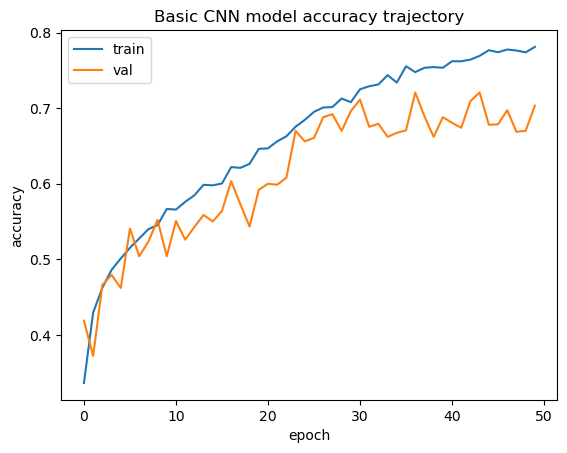

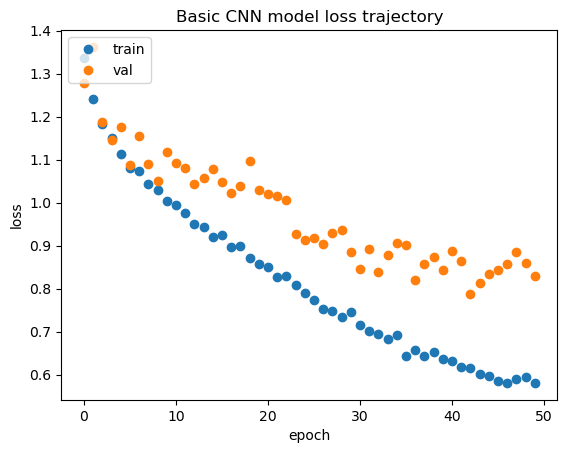

In [16]:
import matplotlib.pyplot as plt

# Plotting accuracy trajectory
plt.plot(hybrid_cnn_lstm_model_results.history['accuracy'])
plt.plot(hybrid_cnn_lstm_model_results.history['val_accuracy'])
plt.title('Basic CNN model accuracy trajectory')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

# Plotting loss trajectory
plt.plot(hybrid_cnn_lstm_model_results.history['loss'],'o')
plt.plot(hybrid_cnn_lstm_model_results.history['val_loss'],'o')
plt.title('Basic CNN model loss trajectory')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

## (vii)(CNN) Testing the performance of the basic CNN model on the held out test set

In [17]:
## Testing the basic CNN model

cnn_score = hybrid_cnn_lstm_model.evaluate(x_test, y_test, verbose=0)
print('Test accuracy of the basic CNN model:',cnn_score[1])

Test accuracy of the basic CNN model: 0.6489841938018799
